In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import PowerTransformer

In [10]:
df = pd.read_csv('../data/feature-engineered/reg_df_reduced.csv')

In [11]:
df.dtypes

Unnamed: 0                         int64
OECD_CLI_index                   float64
CSI_index                        float64
OECD_CLI_index_diff1             float64
OECD_CLI_index_diff3             float64
OECD_CLI_index_pct_change1       float64
gdp_per_capita_diff1             float64
gdp_per_capita_pct_change1       float64
recession_probability_lag1       float64
1_year_rate                      float64
3_months_rate                    float64
6_months_rate                    float64
CPI                              float64
INDPRO                           float64
10_year_rate                     float64
share_price                      float64
unemployment_rate                float64
PPI                              float64
gdp_per_capita                   float64
PPI_CPI_diff                     float64
CPI_rollstd6                     float64
PPI_rollstd3                     float64
PPI_rollstd6                     float64
PPI_rollstd12                    float64
OECD_CLI_index_r


=== Evaluation on Test ===
recession_probability: MAE=1.8151, RMSE=12.3302, R2=0.4882
1_month_recession_probability: MAE=4.0352, RMSE=18.5125, R2=-0.1540
3_month_recession_probability: MAE=4.6907, RMSE=20.7252, R2=-1.8482
6_month_recession_probability: MAE=32.4404, RMSE=46.1744, R2=-9146.3059


/Users/donaldaadithiyan/Personal learn dev/RecessionRadar/venv/lib/python3.12/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/Users/donaldaadithiyan/Personal learn dev/RecessionRadar/venv/lib/python3.12/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/Users/donaldaadithiyan/Personal learn dev/RecessionRadar/venv/lib/python3.12/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/Users/donaldaadithiyan/Personal learn dev/RecessionRadar/venv/l

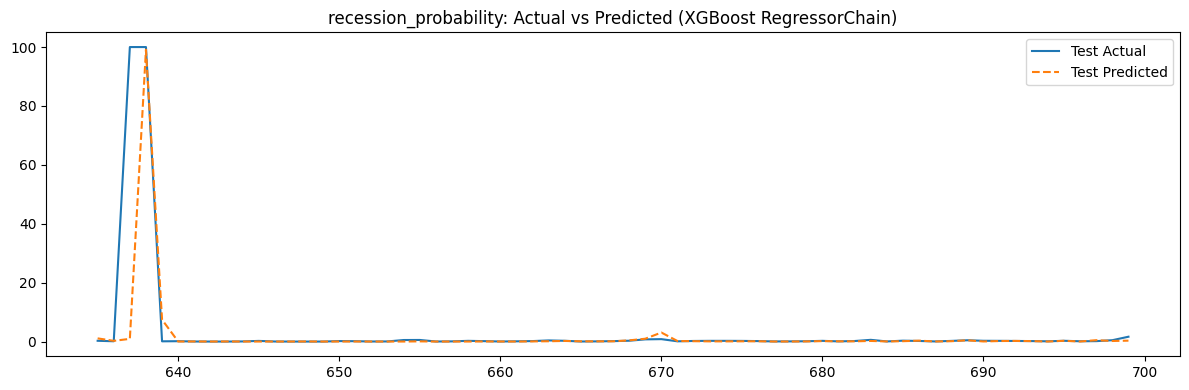

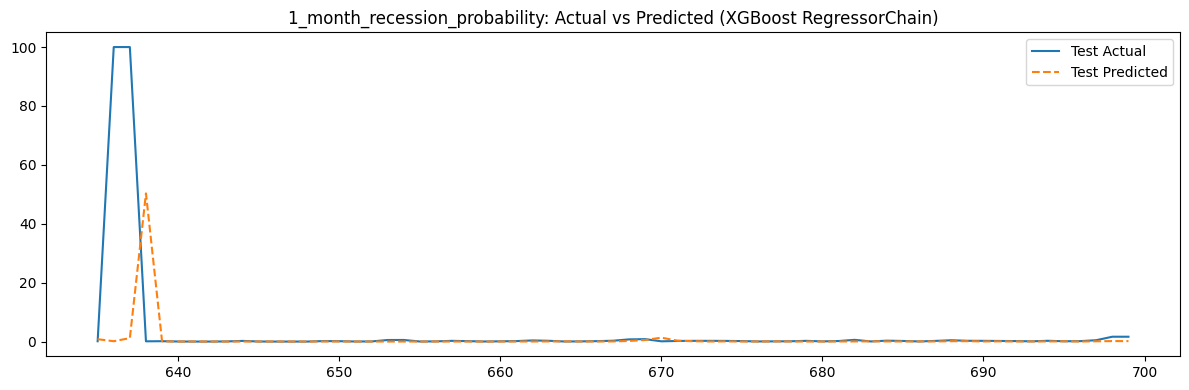

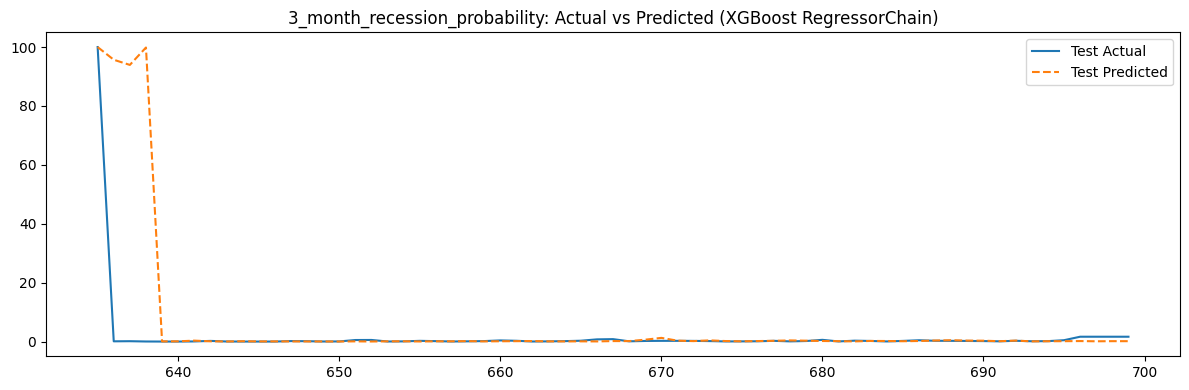

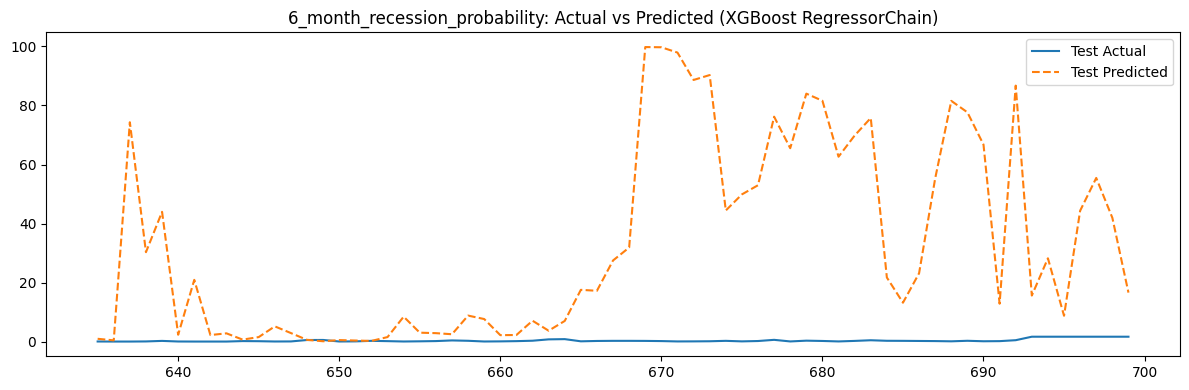

In [14]:
import pandas as pd
import numpy as np
from xgboost import DMatrix, train
from sklearn.multioutput import RegressorChain
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import matplotlib.pyplot as plt

# -------------------------
# Targets
# -------------------------
recession_targets = [
    "recession_probability",
    "1_month_recession_probability",
    "3_month_recession_probability",
    "6_month_recession_probability",
]

# -------------------------
# Split train/test
# -------------------------
split_date = "2020-01-01"
df["date"] = pd.to_datetime(df["date"])
train_df = df[df["date"] < split_date].copy()
test_df  = df[df["date"] >= split_date].copy()

X_train = train_df.drop(columns=recession_targets + ["date"])
X_test  = test_df.drop(columns=recession_targets + ["date"])
y_train = train_df[recession_targets]
y_test  = test_df[recession_targets]

# -------------------------
# Clean NaNs
# -------------------------
def clean_data(X_or_y):
    X_or_y = X_or_y.replace([np.inf, -np.inf], np.nan)
    X_or_y = X_or_y.ffill().bfill()
    X_or_y = X_or_y.fillna(0)
    return X_or_y

X_train = clean_data(X_train)
X_test  = clean_data(X_test)
y_train = clean_data(y_train)
y_test  = clean_data(y_test)

# -------------------------
# Logit transform for [0,100] probabilities
# -------------------------
epsilon = 1e-6
def logit_transform(y):
    y_scaled = np.clip(y / 100, epsilon, 1 - epsilon)
    return np.log(y_scaled / (1 - y_scaled))

def inv_logit_transform(y_logit):
    y_prob = 1 / (1 + np.exp(-y_logit))
    return y_prob * 100

# -------------------------
# Step 1: RegressorChain for first 3 targets
# -------------------------
from sklearn.base import BaseEstimator, RegressorMixin

# Wrapper for XGBoost to make it sklearn compatible
# Wrapper for XGBoost to make it sklearn compatible (fixed for RegressorChain)
class XGBWrapper(BaseEstimator, RegressorMixin):
    def __init__(self, max_depth=5, eta=0.05, subsample=0.9, colsample_bytree=0.9, num_boost_round=500, seed=42):
        self.max_depth = max_depth
        self.eta = eta
        self.subsample = subsample
        self.colsample_bytree = colsample_bytree
        self.num_boost_round = num_boost_round
        self.seed = seed
        self.model_ = None  # single model per wrapper

    def fit(self, X, y):
        # y is 1D when RegressorChain calls fit
        dtrain = DMatrix(X, label=y)
        params = {
            "objective": "reg:squarederror",
            "max_depth": self.max_depth,
            "eta": self.eta,
            "subsample": self.subsample,
            "colsample_bytree": self.colsample_bytree,
            "seed": self.seed,
            "verbosity": 0
        }
        self.model_ = train(params, dtrain, num_boost_round=self.num_boost_round)
        return self

    def predict(self, X):
        dtest = DMatrix(X)
        return self.model_.predict(dtest)


chain_targets = recession_targets[:3]

X_train_chain = X_train.copy()
X_test_chain  = X_test.copy()
y_train_chain = logit_transform(y_train[chain_targets].values)

# Create RegressorChain with XGBWrapper
chain_base = XGBWrapper()
chain_model = RegressorChain(chain_base)
chain_model.fit(X_train_chain, y_train_chain)

preds_chain_logit = chain_model.predict(X_test_chain)
preds_chain_df = pd.DataFrame(
    inv_logit_transform(preds_chain_logit),
    columns=chain_targets,
    index=X_test.index
).clip(0, 100)

# -------------------------
# Step 2: Separate model for 6-month target
# -------------------------
target_6m = "6_month_recession_probability"

X_train_6m = X_train.copy()
X_train_6m[chain_targets] = inv_logit_transform(chain_model.predict(X_train_chain))  # use chain preds as features
X_test_6m = X_test.copy()
X_test_6m[chain_targets] = preds_chain_df

y_train_6m = logit_transform(y_train[target_6m].values)
dtrain_6m = DMatrix(X_train_6m, label=y_train_6m)
dtest_6m  = DMatrix(X_test_6m)

params_6m = {
    "objective": "reg:squarederror",
    "max_depth": 5,
    "eta": 0.05,
    "subsample": 0.9,
    "colsample_bytree": 0.9,
    "seed": 42,
    "verbosity": 0,
}

model_6m = train(params_6m, dtrain_6m, num_boost_round=500)
pred_6m = inv_logit_transform(model_6m.predict(dtest_6m)).clip(0, 100)

# -------------------------
# Combine all predictions
# -------------------------
preds_test_final = preds_chain_df.copy()
preds_test_final[target_6m] = pred_6m

# -------------------------
# Evaluate
# -------------------------
def evaluate(y_true, y_pred, dataset_name="Dataset"):
    print(f"\n=== Evaluation on {dataset_name} ===")
    for target in recession_targets:
        mae = mean_absolute_error(y_true[target], y_pred[target])
        rmse = mean_squared_error(y_true[target], y_pred[target], squared=False)
        r2 = r2_score(y_true[target], y_pred[target])
        print(f"{target}: MAE={mae:.4f}, RMSE={rmse:.4f}, R2={r2:.4f}")

evaluate(y_test, preds_test_final, "Test")

# -------------------------
# Plot Actual vs Predicted
# -------------------------
for target in recession_targets:
    plt.figure(figsize=(12, 4))
    plt.plot(test_df.index, y_test[target], label="Test Actual")
    plt.plot(test_df.index, preds_test_final[target], label="Test Predicted", linestyle="--")
    plt.title(f"{target}: Actual vs Predicted (XGBoost RegressorChain)")
    plt.legend()
    plt.tight_layout()
    plt.show()
